In [67]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin

import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
df1 = pd.read_csv('_1.csv')

Импортируем датафрейм
Группы: A – прямоугольные 16:9
        B – квадратные
        C – прямоугольные 12:4
Задача: нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего.
Будем пользоваться тестом ANOVA

In [33]:
df1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


Проверим, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

In [26]:
pingouin.homoscedasticity(data=df1, dv="events", group="group")

,W,pval,equal_var
levene,2.26226,0.104133,True


Проверим на нормальность распределения

In [29]:
print(scipy.stats.normaltest(df1.query("group == 'A'").events))#normal distribution (pvalue > 0.05)
print(scipy.stats.normaltest(df1.query("group == 'B'").events))#normal distribution (pvalue > 0.05)
print(scipy.stats.normaltest(df1.query("group == 'C'").events))#normal distribution (pvalue > 0.05)

NormaltestResult(statistic=2.1034599402238734, pvalue=0.3493328906085719)
NormaltestResult(statistic=0.8410715800223014, pvalue=0.6566948749848232)
NormaltestResult(statistic=3.243725809054571, pvalue=0.19753037588314626)


Проведём тест с помощью однофакторного дисперсионного анализа

In [30]:
pingouin.anova(data=df1, dv="events", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


Получаем статистически значимые различия(p-value < 0.05)
С помощью критерия Тьюки определим между какими группами есть различия

In [31]:
pingouin.pairwise_tukey(data=df1, dv="events", between="group")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.0,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.0,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.0,1.024138


Статистически значимые различия есть между всеми группами
Больше всего различия с группой В(квадратные), поэтому будем использовать их, как наилучшие 

Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.
Будем пользоваться многофакторным диспресионным анализом

In [54]:
df2 = pd.read_csv('_2.csv')
df2

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0
...,...,...,...,...
99995,60695,control,low,15.0
99996,5934,control,low,16.0
99997,30046,control,low,22.0
99998,26474,control,low,21.0


<Axes: xlabel='events', ylabel='Count'>

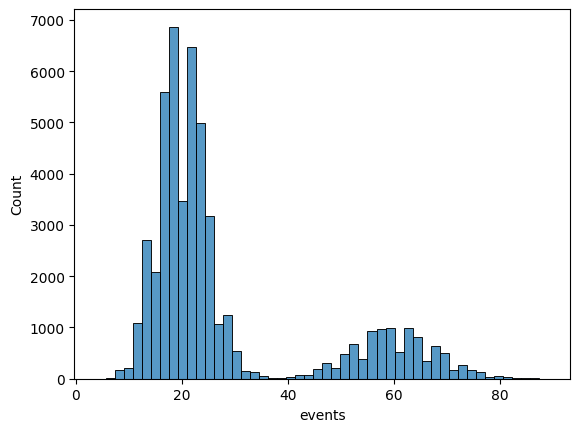

In [55]:
control = df2.query("group == 'control'")
sns.histplot(data=control, x='events', bins=50)

Распределение событий для контрольной и тестовой группы

<Axes: xlabel='events', ylabel='Count'>

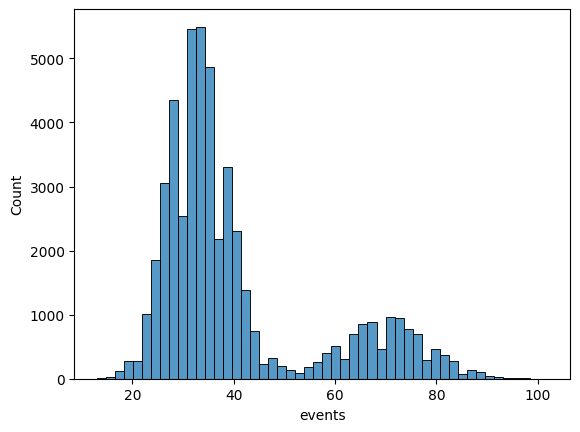

In [56]:
test = df2.query("group == 'test'")
sns.histplot(data=test, x='events', bins=50)

Найдем среднее, медиану и стандартное отклонение по группе и сегменту пользователя

In [61]:
df2.groupby(['group', 'segment'], as_index=False).agg({'events':'mean'}).pivot_table(columns='segment', index='group')

events           
segment     high        low
group                      
control  59.9708  20.031575
test     69.9385  33.025925

In [62]:
df2.groupby(['group', 'segment'], as_index=False).agg({'events':'median'}).pivot_table(columns='segment', index='group')

events      
segment   high   low
group               
control   60.0  20.0
test      70.0  33.0

In [63]:
df2.groupby(['group', 'segment'], as_index=False).agg({'events':'std'}).pivot_table(columns='segment', index='group')

events          
segment      high       low
group                      
control  7.805347  4.473576
test     8.403974  5.720845

Проведем многофакторный тест ANOVA

In [64]:
pingouin.anova(data=df2, dv="events", between=["segment", "group"])

,Source,SS,DF,MS,F,p-unc,np2
0,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
1,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
2,segment * group,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


In [71]:
model_main = smf.ols("events ~ segment * group", data=df2).fit()
anova_lm(model_main, typ = 2)

,sum_sq,df,F,PR(>F)
segment,2.362480e+07,1.0,689756.377484,0.000000e+00
group,3.837195e+06,1.0,112031.864119,0.000000e+00
segment:group,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


In [81]:
df_copy = df2
df_copy['combination'] = df_copy['group'] + ' \ ' + df_copy['segment']

Проверим попарно факторы с помощью критерия Тьюки

In [82]:
pairwise_tukeyhsd(df_copy.events, df_copy.segment).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
high,low,-38.4259,0.0,-38.5583,-38.2935,True


In [83]:
pairwise_tukeyhsd(df_copy.events, df_copy.group).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control,test,12.389,0.0,12.185,12.593,True


In [84]:
pairwise_tukeyhsd(df_copy.events, df_copy.combination).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control \ high,control \ low,-39.9392,0.0,-40.1073,-39.7711,True
control \ high,test \ high,9.9677,0.0,9.7551,10.1803,True
control \ high,test \ low,-26.9449,0.0,-27.113,-26.7768,True
control \ low,test \ high,49.9069,0.0,49.7388,50.075,True
control \ low,test \ low,12.9944,0.0,12.888,13.1007,True
test \ high,test \ low,-36.9126,0.0,-37.0807,-36.7445,True


<Axes: xlabel='segment', ylabel='events'>

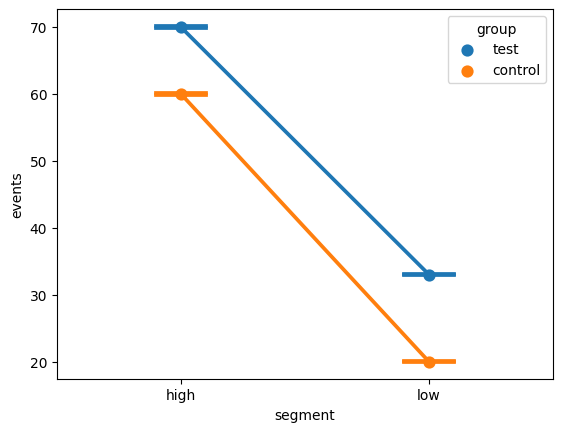

In [95]:
sns.pointplot(x="segment", y="events", hue="group", data=df2, capsize=0.2)

Вывод:Оба фактора(group и segment) оказались значимыми, как и их взаимодействие. Судя по графику, для всех групп значение events увеличилось, поэтому следует выкатить новую верисию кнопки оформления заказа, с разбивкой по сегменту клиента